
<center>
<font color="cyan"><h2 > BreakPoint(Human in Loop)</h2></font>
<center>
<h3>interupt before</h3>
<h3>interupt before</h3>
<h3>Node Interrupt</h3>
</center>
</center>



<p>Langgraph offers several ways to get or update agent state systematically to support various human-in-loop workflows</p>
<ul>
<li>Approval : We can interupt agent, surface state to a user, and allow the user to accept an action.</li>
<li>Debugging : We can rewind the graph to reproduce or avoid issues </li>
<li>Editing : You can modify the state</li>
</ul>

Let's see the <code>breakpoints</code> , which provide a simple way to stop the graph at specific steps.


BreakPoint for Human approval
<p>All we need to do is simply compile the graph with interrupt_before=["tools"] where tools is our tools node </p>

In [1]:
# defining tools
from langchain_openai import ChatOpenAI

def multiply(a:int,b:int)-> int:
    """helps to multiply two number 

    Args:
        a : first int
        b : second int
    """
    return a*b
tools = [multiply]
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)


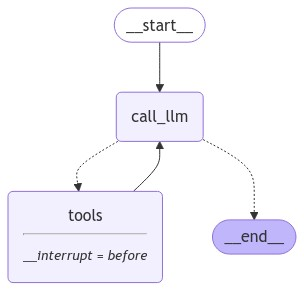

In [2]:
from langgraph.graph import START,END,StateGraph,MessagesState
from IPython.display import display,Image
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import tools_condition,ToolNode
from langgraph.checkpoint.memory import MemorySaver
system_message = SystemMessage(content="You are a helpful assistant who can perform arithmetic operations.")
#state
class State(MessagesState):
    pass

#node
def call_llm(state:State):
    response = llm_with_tools.invoke([system_message]+state['messages'])
    return {'messages':response}

# graph
builder = StateGraph(State)
builder.add_node('call_llm',call_llm)
builder.add_node('tools',ToolNode(tools))


builder.add_edge(START,'call_llm')
builder.add_conditional_edges('call_llm',tools_condition)
builder.add_edge('tools','call_llm')


#compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['tools'],checkpointer=memory)



display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
config = {'configurable':{'thread_id':1}}
events = []
for event in graph.stream({'messages':"Multiply 2 and 3"}, config,stream_mode='values'):
    events.append(event)
    print(event['messages'][-1].pretty_print())

================================ Human Message =================================

Multiply 2 and 3
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_yai3wJnsft6dfYNPhTdtyGiu)
 Call ID: call_yai3wJnsft6dfYNPhTdtyGiu
  Args:
    a: 2
    b: 3
None


In [13]:
event

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b23c58f4-8518-4d23-a008-c1ce9e8f4901'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c1cc7e65-8c83-4b46-93cd-ad3e59fc9b0a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_token

In [15]:
state = graph.get_state(config)
state.next

('tools',)

In [17]:
print(state)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b23c58f4-8518-4d23-a008-c1ce9e8f4901'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c1cc7e65-8c83-4b46-93cd-ad3e59fc9b0a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'type': 'tool_call'}], usage_metadata={'input_tokens'

In [18]:
events

[{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b23c58f4-8518-4d23-a008-c1ce9e8f4901')]},
 {'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b23c58f4-8518-4d23-a008-c1ce9e8f4901'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yai3wJnsft6dfYNPhTdtyGiu', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c1cc7e65-8c83-4b46-93cd-ad3e59fc9b0a-0', tool_calls=[{'name': '

In [19]:
len(events)

2

In [20]:
for event in graph.stream(None, config,stream_mode='values'):
    events.append(event)
    print(event['messages'][-1].pretty_print())

================================== Ai Message ==================================
Tool Calls:
  multiply (call_yai3wJnsft6dfYNPhTdtyGiu)
 Call ID: call_yai3wJnsft6dfYNPhTdtyGiu
  Args:
    a: 2
    b: 3
None
================================= Tool Message =================================
Name: multiply

6
None
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
None


In [21]:
len(events)

5

#### User Approval

In [9]:
config = {'configurable':{'thread_id':21}}
print("state history : ",graph.get_state_history(config),"\n", end="*"*20)
for event in graph.stream({'messages':"What is 3 * 3?"},config,stream_mode='values'):
    print(event['messages'][-1].pretty_print())
print("Current History of state : \n",graph.get_state(config),"\n",end="-"*25)


state history :  <generator object Pregel.get_state_history at 0x10f9b3b00> 
********************================================ Human Message =================================

What is 3 * 3?
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_22IdEgGGboLqdH8Yt5axfedt)
 Call ID: call_22IdEgGGboLqdH8Yt5axfedt
  Args:
    a: 3
    b: 3
None
Current History of state : 
 StateSnapshot(values={'messages': [HumanMessage(content='What is 3 * 3?', additional_kwargs={}, response_metadata={}, id='0a1abbd4-3886-4ea3-ad0d-a25b34188a54'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_22IdEgGGboLqdH8Yt5axfedt', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 72, 'total_tokens': 89, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 

In [10]:
user_approval = "yes"
print(f'User approval: {user_approval}')


User approval: yes


In [ ]:
user_approval = "no"
print(f'User approval: {user_approval}')

In [11]:
if user_approval.lower() == 'yes':
    for event in graph.stream(None,config,stream_mode='values'):
        print(event['messages'][-1].pretty_print())
print("Again Current History of state : \n",graph.get_state(config),"\n",end="-"*25)
print("state history : ",graph.get_state_history(config),"\n",end="*"*20)

================================== Ai Message ==================================
Tool Calls:
  multiply (call_22IdEgGGboLqdH8Yt5axfedt)
 Call ID: call_22IdEgGGboLqdH8Yt5axfedt
  Args:
    a: 3
    b: 3
None
================================= Tool Message =================================
Name: multiply

9
None
================================== Ai Message ==================================

3 * 3 is 9.
None
Again Current History of state : 
 StateSnapshot(values={'messages': [HumanMessage(content='What is 3 * 3?', additional_kwargs={}, response_metadata={}, id='0a1abbd4-3886-4ea3-ad0d-a25b34188a54'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_22IdEgGGboLqdH8Yt5axfedt', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 72, 'total_tokens': 89, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction

## We can modify the graph state when we use breakpoint.

In [25]:
# simple tool
from langchain_openai import ChatOpenAI
def multiply(a:int,b:int)-> int:
    """helps to muplitply two number

    Args:
        a : first number
        b : second number
    """
    return a * b
llm = ChatOpenAI(model='gpt-4o-mini')
tools = [multiply]
llm_with_tools = llm.bind_tools(tools)

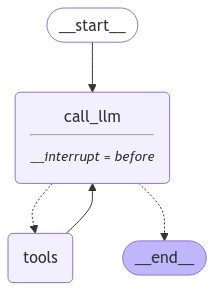

In [26]:
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.graph import START,END,StateGraph,MessagesState
from langgraph.prebuilt import tools_condition,ToolNode
from IPython.display import display,Image
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
# state
class State(MessagesState):
    pass

# node
def call_llm(state):
    return({'messages':[SystemMessage(content='You are an AI assistant who can do arithmatic operations.')] + [llm_with_tools.invoke(state['messages'])]})    

builder = StateGraph(State)
builder.add_node('call_llm',call_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'call_llm')
builder.add_conditional_edges('call_llm',tools_condition)
builder.add_edge('tools','call_llm')

graph = builder.compile(checkpointer=memory,interrupt_before=['call_llm'])

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config = {'configurable':{'thread_id':123}}
graph.invoke({'messages':[HumanMessage(content="What is 4 * 4")]}, config)

{'messages': [HumanMessage(content='What is 4 * 4', additional_kwargs={}, response_metadata={}, id='ad5092b5-059a-4e88-8fec-044b83cf1a47')]}

In [28]:
graph_state = graph.get_state(config)
print(graph_state)

StateSnapshot(values={'messages': [HumanMessage(content='What is 4 * 4', additional_kwargs={}, response_metadata={}, id='ad5092b5-059a-4e88-8fec-044b83cf1a47')]}, next=('call_llm',), config={'configurable': {'thread_id': 123, 'checkpoint_ns': '', 'checkpoint_id': '1efa2a37-42a0-6fa2-8000-006c2a901b76'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-11-14T16:13:58.405713+00:00', parent_config={'configurable': {'thread_id': 123, 'checkpoint_ns': '', 'checkpoint_id': '1efa2a37-429e-6a2c-bfff-57db507316da'}}, tasks=(PregelTask(id='058511b4-239e-3885-4f41-bf8406705f25', name='call_llm', path=('__pregel_pull', 'call_llm'), error=None, interrupts=(), state=None, result=None),))


In [29]:
print(graph_state.next)

('call_llm',)


## Modify the state before the next node will call.

In [30]:
graph.update_state(
    config=config,
    values={'messages' : [HumanMessage(content="No,what is 9 * 9?")]}
)

{'configurable': {'thread_id': 123,
  'checkpoint_ns': '',
  'checkpoint_id': '1efa2a37-42d4-6ed8-8001-5d26f702d180'}}

<p>As we are passing new message , and used MessageSatate while defining the class. The default reducer will append to messages. To update the existing message we need to pass the message id.</p>

In [31]:
print(graph.get_state(config))

StateSnapshot(values={'messages': [HumanMessage(content='What is 4 * 4', additional_kwargs={}, response_metadata={}, id='ad5092b5-059a-4e88-8fec-044b83cf1a47'), HumanMessage(content='No,what is 9 * 9?', additional_kwargs={}, response_metadata={}, id='0e29fca9-51db-4f7a-a33b-3bd702861650')]}, next=('call_llm',), config={'configurable': {'thread_id': 123, 'checkpoint_ns': '', 'checkpoint_id': '1efa2a37-42d4-6ed8-8001-5d26f702d180'}}, metadata={'source': 'update', 'step': 1, 'writes': {'__start__': {'messages': [HumanMessage(content='No,what is 9 * 9?', additional_kwargs={}, response_metadata={}, id='0e29fca9-51db-4f7a-a33b-3bd702861650')]}}, 'parents': {}}, created_at='2024-11-14T16:13:58.426990+00:00', parent_config={'configurable': {'thread_id': 123, 'checkpoint_ns': '', 'checkpoint_id': '1efa2a37-42a0-6fa2-8000-006c2a901b76'}}, tasks=(PregelTask(id='d69424b0-ca22-b202-711c-9120848db9a5', name='call_llm', path=('__pregel_pull', 'call_llm'), error=None, interrupts=(), state=None, result

In [32]:
graph.invoke(None,config)

{'messages': [HumanMessage(content='What is 4 * 4', additional_kwargs={}, response_metadata={}, id='ad5092b5-059a-4e88-8fec-044b83cf1a47'),
  HumanMessage(content='No,what is 9 * 9?', additional_kwargs={}, response_metadata={}, id='0e29fca9-51db-4f7a-a33b-3bd702861650'),
  SystemMessage(content='You are an AI assistant who can do arithmatic operations.', additional_kwargs={}, response_metadata={}, id='a39c4ad9-9cea-4ba3-b10b-d8643e050a7d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5gd36Mb0qibQyihesG62rMEs', 'function': {'arguments': '{"a": 4, "b": 4}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_fnhK5T0LBTM45eazXSRCRdBP', 'function': {'arguments': '{"a": 9, "b": 9}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 76, 'total_tokens': 126, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_predi

# We can Interrupt the node in the middle.To stop the execution of graph at some point.
<code> from langgraph.errors import NodeInterrupt </code>